CV

In [1]:
from CV_train import EfficientNet, CVDataset
from torch.utils import data

In [2]:
en_b0 = EfficientNet()
animals_10_dataset = CVDataset("data/raw-img", 0.2, 0.1, en_b0.connector)
batch_size = 64

train_dataloader = data.DataLoader(
    data.Subset(animals_10_dataset, animals_10_dataset.train_index),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)
eval_dataloader = data.DataLoader(
    data.Subset(animals_10_dataset, animals_10_dataset.eval_index),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)
test_dataloader = data.DataLoader(
    data.Subset(animals_10_dataset, animals_10_dataset.test_index),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)

file, folder: e83db7072afd013ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg, elephant


In [21]:
new_en_b0 = EfficientNet()
new_en_b0.load("./models")
new_en_b0.train(train_dataloader, eval_dataloader, train_steps = 300)
new_en_b0.save("models/new_en_b0_first_run.pt")

In [ ]:
"""
the output of training will be similar to:
precision    recall  f1-score   support

   butterfly       0.98      0.98      0.98       258
         cat       0.97      0.93      0.95       254
     chicken       0.95      0.98      0.96       224
         cow       0.92      0.92      0.92       243
         dog       0.91      0.91      0.91       210
    elephant       0.98      0.98      0.98       238
       horse       0.92      0.94      0.93       238
         NoF       0.98      0.97      0.97       240
       sheep       0.97      0.95      0.96       241
      spider       0.95      0.98      0.97       241
    squirrel       0.97      0.95      0.96       237

    accuracy                           0.95      2624
   macro avg       0.95      0.95      0.95      2624
weighted avg       0.95      0.95      0.95      2624
"""

In [22]:
mat, rep = new_en_b0.eval_statistics(test_dataloader)

Results of CV model on test dataset

In [23]:
print(mat)

[[86  0  0  0  0  0  0  0  0  0  0]
 [ 0 63  0  0  2  1  0  1  0  0  0]
 [ 0  0 57  0  0  0  1  0  0  0  0]
 [ 0  0  0 68  2  0  2  0  4  0  0]
 [ 0  0  0  1 53  1  4  1  0  0  0]
 [ 0  0  0  0  0 81  0  0  0  0  0]
 [ 0  0  0  3  0  1 68  0  0  0  0]
 [ 0  0  0  0  0  0  0 81  0  0  0]
 [ 0  0  1  1  2  1  0  0 84  0  0]
 [ 2  1  0  0  0  0  0  0  0 79  0]
 [ 0  1  2  2  2  0  0  0  0  0 73]]


In [24]:
print(rep)

              precision    recall  f1-score   support

   butterfly       0.98      1.00      0.99        86
         cat       0.97      0.94      0.95        67
     chicken       0.95      0.98      0.97        58
         cow       0.91      0.89      0.90        76
         dog       0.87      0.88      0.88        60
    elephant       0.95      1.00      0.98        81
       horse       0.91      0.94      0.93        72
         NoF       0.98      1.00      0.99        81
       sheep       0.95      0.94      0.95        89
      spider       1.00      0.96      0.98        82
    squirrel       1.00      0.91      0.95        80

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832



There is no pure datasets in this world

NLP part

In [26]:
#I used LLM for generating presets and with prompt :" prompt here"
def generate_uni_test_template(animal_name):
    test_presets = [
        f"Look! A majestic {animal_name} is visible", #base
        f"I think there might be a {animal_name} in this photo",#base
        f"Is this a picture of a {animal_name}",#base
        f"The picture features a big, brown {animal_name}", #base
        f"I'm looking for a {animal_name}. Is it here?",#base
        f"It's a {animal_name}! I'm sure of it", #base
        f"An {animal_name} can be seen on the left side", #base
        f"There is a {animal_name} grazing in the field" #base*(if we want to answer on all possible questions including the env it's only possible with zero-shot image classifiers like CLIP)
        f"This animal is definitely a {animal_name}" #base
        f"I don't see a {animal_name} anywhere", #negative example that breaks our model because of NER structure
        f"A cute little {animal_name} is on the branch" #base
        f"The photo contains an animal; I believe it's a {animal_name}", #base
        f"This is a great picture of a human and an {animal_name}", #multiple ents
        f"Can you confirm that this isn't a {animal_name}?", #negative example that breaks our model because of NER structure
        f"This is a {'-'.join(animal_name)}", #misstypo
        f"{animal_name}." #base
    ]
    return test_presets

def denial_uni_test(animal_name):
    test_presets = [
        f"I don't see a {animal_name} anywhere", #negative example that breaks our model because of NER structure
        f"Can you confirm that this isn't a {animal_name}?", #negative example that breaks our model because of NER structure
    ]
    return test_presets

def generate_bi_test_template(label, decoy):
    test_presets = [
        f"There appears to be a {label} or a {decoy}", #multiple ents
        f"I saw a {label} on this picture and a small {decoy} earlier", #multiple ents
    ]
    return test_presets

In [28]:
negative_labels = ["apple", "plane", "axe", "student", "kurtosis"]

positive_labels = list(animals_10_dataset.label_to_index.keys())
positive_labels.remove("NoF")
positive_labels

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [31]:
import numpy as np
import itertools

animals_combination = list(itertools.product(positive_labels, positive_labels))
entity_combination = list(itertools.product(positive_labels, negative_labels))
eval_corpus_features = []
eval_corpus_targets = []

for names in animals_combination:
    label = names[0]
    decoy = names[1]
    if label == decoy:
        uni_examples = generate_uni_test_template(label)
        eval_corpus_features.extend(uni_examples)
        eval_corpus_targets.extend(np.ones(len(uni_examples)) * animals_10_dataset.label_to_index[label])

        uni_examples = denial_uni_test(label)
        eval_corpus_features.extend(uni_examples)
        eval_corpus_targets.extend(np.ones(len(uni_examples)) * animals_10_dataset.label_to_index['NoF'])
    else:
        bi_examples = generate_bi_test_template(label, decoy)
        eval_corpus_features.extend(bi_examples)
        eval_corpus_targets.extend(np.ones(len(bi_examples)) * animals_10_dataset.label_to_index[label])

for names in entity_combination:
    label = names[0]
    decoy = names[1]

    bi_examples = generate_bi_test_template(label, decoy)
    eval_corpus_features.extend(bi_examples)
    eval_corpus_targets.extend(np.ones(len(bi_examples)) * animals_10_dataset.label_to_index[label])

In [32]:
ner_classes = positive_labels
nli_classes = []
for animal in ner_classes:
    nli_classes.extend([f"there is a {animal}", f"there is no {animal}"])

In [42]:
index_to_label = {v:k for k, v in animals_10_dataset.label_to_index.items()}

NER

In [56]:
from gliner import GLiNER

model = GLiNER.from_pretrained("gliner-community/gliner_large-v2.5", load_tokenizer=True)

import torch
model.to(torch.device("cuda:0"))
text = eval_corpus_features

predictions = []
labels = ner_classes
for line,target in zip(text, eval_corpus_targets):
    prediction = model.predict_entities(line, labels, threshold = 0.75)
    #print(prediction)
    #print([predict["label"] for predict in prediction])
    if len(prediction) == 0:
        prediction = "NoF"
    elif index_to_label[target] in [predict["label"] for predict in prediction]:
        prediction = index_to_label[target]
    else:
        prediction = prediction[0]["label"]
    predictions.append(prediction)

# predicted_labels = []
# for prediction in predictions:
#     try:
#         label = prediction[0]["label"]
#         predicted_labels.append(label)
#     except:
#         predicted_labels.append("NoF")

Fetching 10 files: 100%|██████████| 10/10 [00:00<?, ?it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [58]:
predicted_ids = [animals_10_dataset.label_to_index[label] for label in predictions]

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(eval_corpus_targets, predicted_ids)
conf_report = classification_report(eval_corpus_targets, predicted_ids, target_names=animals_10_dataset.label_to_index.keys())

In [60]:
conf_matrix

array([[38,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0],
       [ 0, 38,  0,  0,  0,  0,  0,  3,  0,  0,  0],
       [ 0,  0, 38,  0,  0,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0, 39,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0, 38,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 38,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 38,  3,  0,  0,  0],
       [ 2,  2,  2,  2,  2,  2,  2,  0,  2,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  3, 38,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0, 39,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  0, 38]])

In [61]:
print(conf_report)

              precision    recall  f1-score   support

   butterfly       0.95      0.93      0.94        41
         cat       0.95      0.93      0.94        41
     chicken       0.95      0.93      0.94        41
         cow       0.95      0.95      0.95        41
         dog       0.95      0.93      0.94        41
    elephant       0.95      0.93      0.94        41
       horse       0.95      0.93      0.94        41
         NoF       0.00      0.00      0.00        20
       sheep       0.95      0.93      0.94        41
      spider       0.95      0.95      0.95        41
    squirrel       0.95      0.93      0.94        41

    accuracy                           0.89       430
   macro avg       0.86      0.85      0.86       430
weighted avg       0.91      0.89      0.90       430



We won't be able to find such entity class that will triger whenever other are not triggered

NLI based approach

In [62]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

text = eval_corpus_features

predictions = []
labels = nli_classes

for line in text:
    prediction = classifier(line, labels)
    prediction = prediction["labels"][0]
    predictions.append(prediction)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [83]:
corrected_predictions = []
for target, predicted in zip(eval_corpus_targets, predictions):
    if predicted.split(' ')[-2] == 'no' and predicted.split(' ')[-1] == index_to_label[target]:
        corrected_predictions.append(animals_10_dataset.label_to_index['NoF'])
    elif predicted.split(' ')[-1] == index_to_label[target]:
        corrected_predictions.append(target)
    elif predicted.split(' ')[-2] == 'no' and predicted.split(' ')[-1] != index_to_label[target]:
        corrected_predictions.append(target)
    else:
        corrected_predictions.append(animals_10_dataset.label_to_index[predicted.split(' ')[-1]])

In [84]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(eval_corpus_targets, corrected_predictions)
conf_report = classification_report(eval_corpus_targets, corrected_predictions, target_names=animals_10_dataset.label_to_index.keys())
conf_matrix

array([[40,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 40,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  0,  0, 38,  0,  0,  1,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 40,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 40,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 39,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 40,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 40]])

In [85]:
print(conf_report)

              precision    recall  f1-score   support

   butterfly       0.98      0.98      0.98        41
         cat       1.00      0.98      0.99        41
     chicken       1.00      0.98      0.99        41
         cow       1.00      0.98      0.99        41
         dog       1.00      0.93      0.96        41
    elephant       1.00      0.98      0.99        41
       horse       1.00      0.98      0.99        41
         NoF       0.67      1.00      0.80        20
       sheep       1.00      0.95      0.97        41
      spider       0.95      0.98      0.96        41
    squirrel       1.00      0.98      0.99        41

    accuracy                           0.97       430
   macro avg       0.96      0.97      0.96       430
weighted avg       0.98      0.97      0.97       430



It solves the problem from finite amount of classes, the problem is finite...

CLIP (2nd head for ner and CV) based approach

In [90]:
from CLIP_inference import predict
from PIL import Image

In [108]:
images = ["data/raw-img/horse/OIP-0aMd_hJDVuMGMvxr1FTLSQHaGP.jpeg", "data/raw-img/spider/e03db4072cf01c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640.jpg"] # - white horse "data/raw-img/horse/OIP-0b4F6_zQfANx6SOMUAlWwgHaFw.jpeg
text = ['white horse', 'not white horse', '8 legged bug', 'ant', 'duck', 'not web']
im_horse = Image.open(images[0])

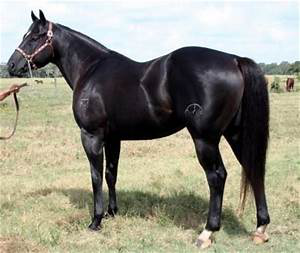

In [114]:
im_horse

In [109]:
im_spider = Image.open(images[1])

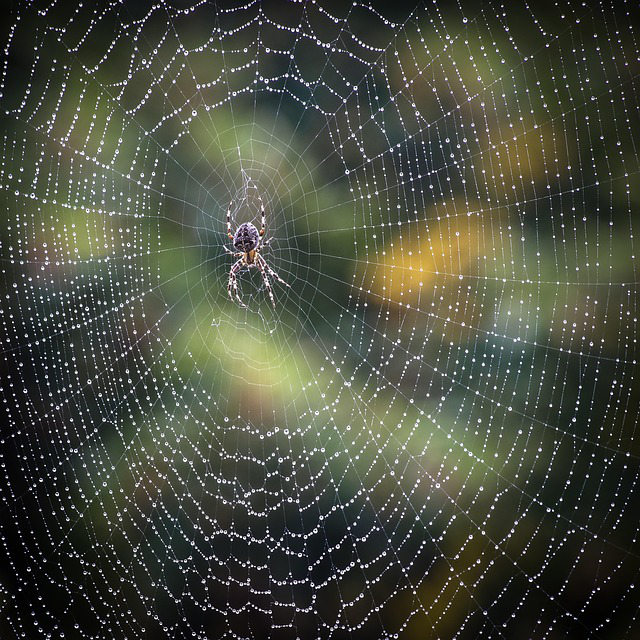

In [115]:
im_spider

In [110]:
predict(model_type = 'base', model_path='./models', texts = text, images =[im_horse] )

Device set to use cuda:0


['not white horse']

In [111]:
predict(model_type = 'gliner', model_path='./models', texts = text, images =[im_horse] )

Fetching 10 files: 100%|██████████| 10/10 [00:00<?, ?it/s]


['8 legged bug']

In [112]:
predict(model_type = 'base', model_path='./models', texts = text, images =[im_spider] )

Device set to use cuda:0


['not web']

In [113]:
predict(model_type = 'gliner', model_path='./models', texts = text, images =[im_spider] )

Fetching 10 files: 100%|██████████| 10/10 [00:00<?, ?it/s]


['8 legged bug']

As we can see, I didn't finished training new text encoder and CLIP also isn't a magic stick. But still, it worth a try (